In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns

## Create a dataset for classification

(10000, 2) (10000,)


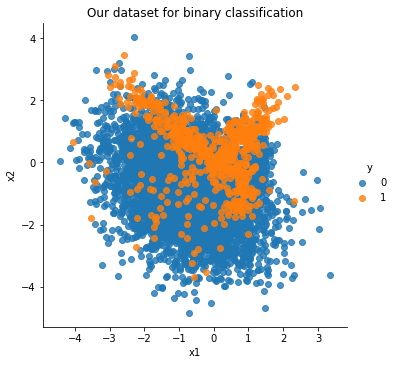

In [41]:
n_samples = 10000
n_features = 2
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_redundant=0,
                           weights=[0.95, 0.05], # control class imbalance
                           random_state=42,
                           flip_y=0.04,
                           class_sep=0.8)
print(X.shape, y.shape)
df = pd.DataFrame({'x1' : X[:,0],
                   'x2' : X[:,1],
                   'y'  : y})
sns.lmplot(x='x1', y='x2', hue='y', data=df,
          fit_reg=False)
plt.title("Our dataset for binary classification");

## Define routines for:
* Training a classification model
* Calculating performance of the trained model using different metrics
* Plot ROC curve
* Plot Precision-Recall curve
* Visualize the confusion matrix of the trained model

In [135]:
def plot_roc(y_test_sub, prediction_probs, ax):
    fpr, tpr, _ = roc_curve(y_test_sub, prediction_probs)
    ax = plt.subplot(1,3,1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    roc_auc = roc_auc_score(y_test_sub, prediction_probs)
    ax.set_title('ROC curve (AUC score is {0:0.2})'.format(roc_auc))
    ax.set_ylabel('tpr')
    ax.set_xlabel('fpr')
    ax.set_aspect(1)
    ax.grid()
    return ax
    
def plot_pr(y_test_sub, prediction_probs, ax=None, do_plot=True):
    precision, recall, _ = metrics.precision_recall_curve(y_test_sub, prediction_probs)
    idxs = np.argsort(recall)
    prec_rec_auc = metrics.auc(recall[idxs], precision[idxs])
    if do_plot is True:
        ax.plot(recall, precision)
        ax.set_title('PR curve (AUC score is {0:0.2})'.format(prec_rec_auc))
        ax.set_ylabel('precision')
        ax.set_xlabel('recall')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_aspect(1)
        ax.grid()
    return ax, prec_rec_auc

def plot_confusion(cm, ax):
    ax = sns.heatmap(cm, cbar=False,ax=ax,
                     square=True, linewidths=2.,
                     annot=True, annot_kws={'fontsize':25}, fmt='d',
                     cmap=sns.cubehelix_palette(8))
    ax.set_ylabel('Class')
    ax.set_xlabel('Predictions')
    ax.set_yticklabels(['$N$', '$P$'], rotation=0, fontsize=17)
    ax.set_xticklabels(['$0$', '$1$'], fontsize=17)
    ax.set_title('Confusion matrix')
    plt.show()
    plt.tight_layout()
    return ax

# Train the model and evaluate performance on the hold-out set

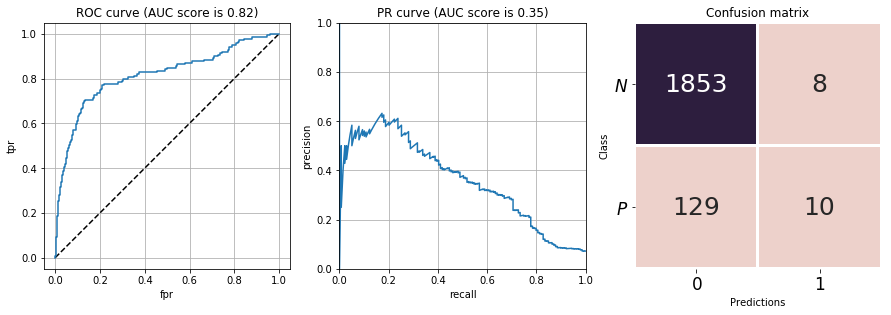

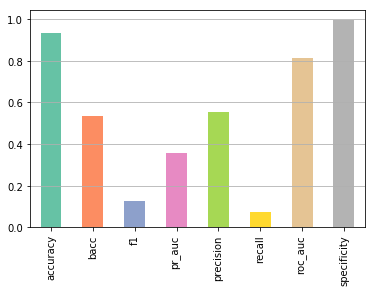

In [136]:
def fit(X_train, y_train):
    # classifier = svm.SVC(probability=True,
    #                      class_weight={1: len(y_train[y_train==False])/len(y_train[y_train==True])})
    classifier = linear_model.LogisticRegression(random_state=42, solver='lbfgs')

    model = Pipeline([
        ('classifier', classifier)
    ])
    model = model.fit(X_train, y_train)
    return model

def predict_evaluate_plot(model, X_test, y_test, do_plot=False):
    '''
    - Make predictions on the hold-out set
    - Evaluate these predictions using multiple performance metrics
    - Visualize ROC curve, PR curve and confusion matrix of the trained model
    return perfromance results
    '''
    prediction_probs = model.predict_proba(X_test)[:,1]
    predictions = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, prediction_probs)
    fpr, tpr, _ = roc_curve(y_test, prediction_probs)
    cm = confusion_matrix(y_test, predictions)
    if do_plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
        ax1 = plot_roc(y_test, prediction_probs, ax1)
        ax2, prec_rec_auc = plot_pr(y_test, prediction_probs, ax=ax2)
        plot_confusion(cm, ax3)
    else:
        # calc area under pr curv ebut without plotting
        _, prec_rec_auc = plot_pr(y_test, prediction_probs, ax=None, do_plot=False)
    spc = cm[0,0]/(cm[0,0]+cm[0,1])
    assert(metrics.auc(fpr, tpr) == roc_auc)
    df_tmp = pd.DataFrame(
        {
         'pos_ratio' : len(np.flatnonzero(y_test > 0))*1./len(y_test),
         'roc_auc' : roc_auc,
         'pr_auc'  : prec_rec_auc,
         'accuracy': metrics.accuracy_score(y_test, predictions),
         'f1'      : metrics.f1_score(y_test, predictions),
         'recall'  : metrics.recall_score(y_test, predictions),
         'precision' : metrics.precision_score(y_test, predictions),
         'specificity' : spc,
         'bacc'    : 0.5*(metrics.recall_score(y_test, predictions) + spc)
        },
        index=[0])
    return df_tmp
test_sz = 0.2 # 20% of the data for the hold-out set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_sz, random_state=42)
model = fit(X_train, y_train)
df_scores = predict_evaluate_plot(model, X_test, y_test, do_plot=True)
df_scores.drop(['pos_ratio'],
               axis=1,
               inplace=False).iloc[0].plot(kind='bar', color=sns.color_palette("Set2", 10))
plt.grid(axis='y')

# Evaluate performance for different class distributions
* The class distribution in the training set is fixed.
* The model is already trained on the training set
* We evaluate the model on multiple subsets of the hold-out sets. These subsets differ in the porportion between the negative and the positive class. (i.e. test the classifier multiple times, take away more positive test samples every time)

In [142]:
def scores_vs_pos_size(model, X_test, y_test,
                       pos_ratios, do_plot=False):
    df = pd.DataFrame()
    for pos_ratio in pos_ratios:
        neg_idxs = np.flatnonzero(y_test <= 0)
        pos_idxs = np.flatnonzero(y_test > 0)
        # take away positive examples
        pos_idxs = pos_idxs[:int(len(pos_idxs)*pos_ratio)]
        sub_idxs = np.hstack((neg_idxs, pos_idxs))
        df_tmp = predict_evaluate_plot(model, X_test[sub_idxs,:], y_test[sub_idxs], do_plot=False)
        df = df.append(df_tmp)
    return df
df = scores_vs_pos_size(model, X_test, y_test, np.arange(0.1,1.1,0.1), do_plot=False)

# Performance as a function of postive to negative ratio in the hold-out set

As we change the distribution on the hold-out set we can see how sensitive the performance measure is to the change in proportion.

/home/kashefy/miniconda3/envs/y/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


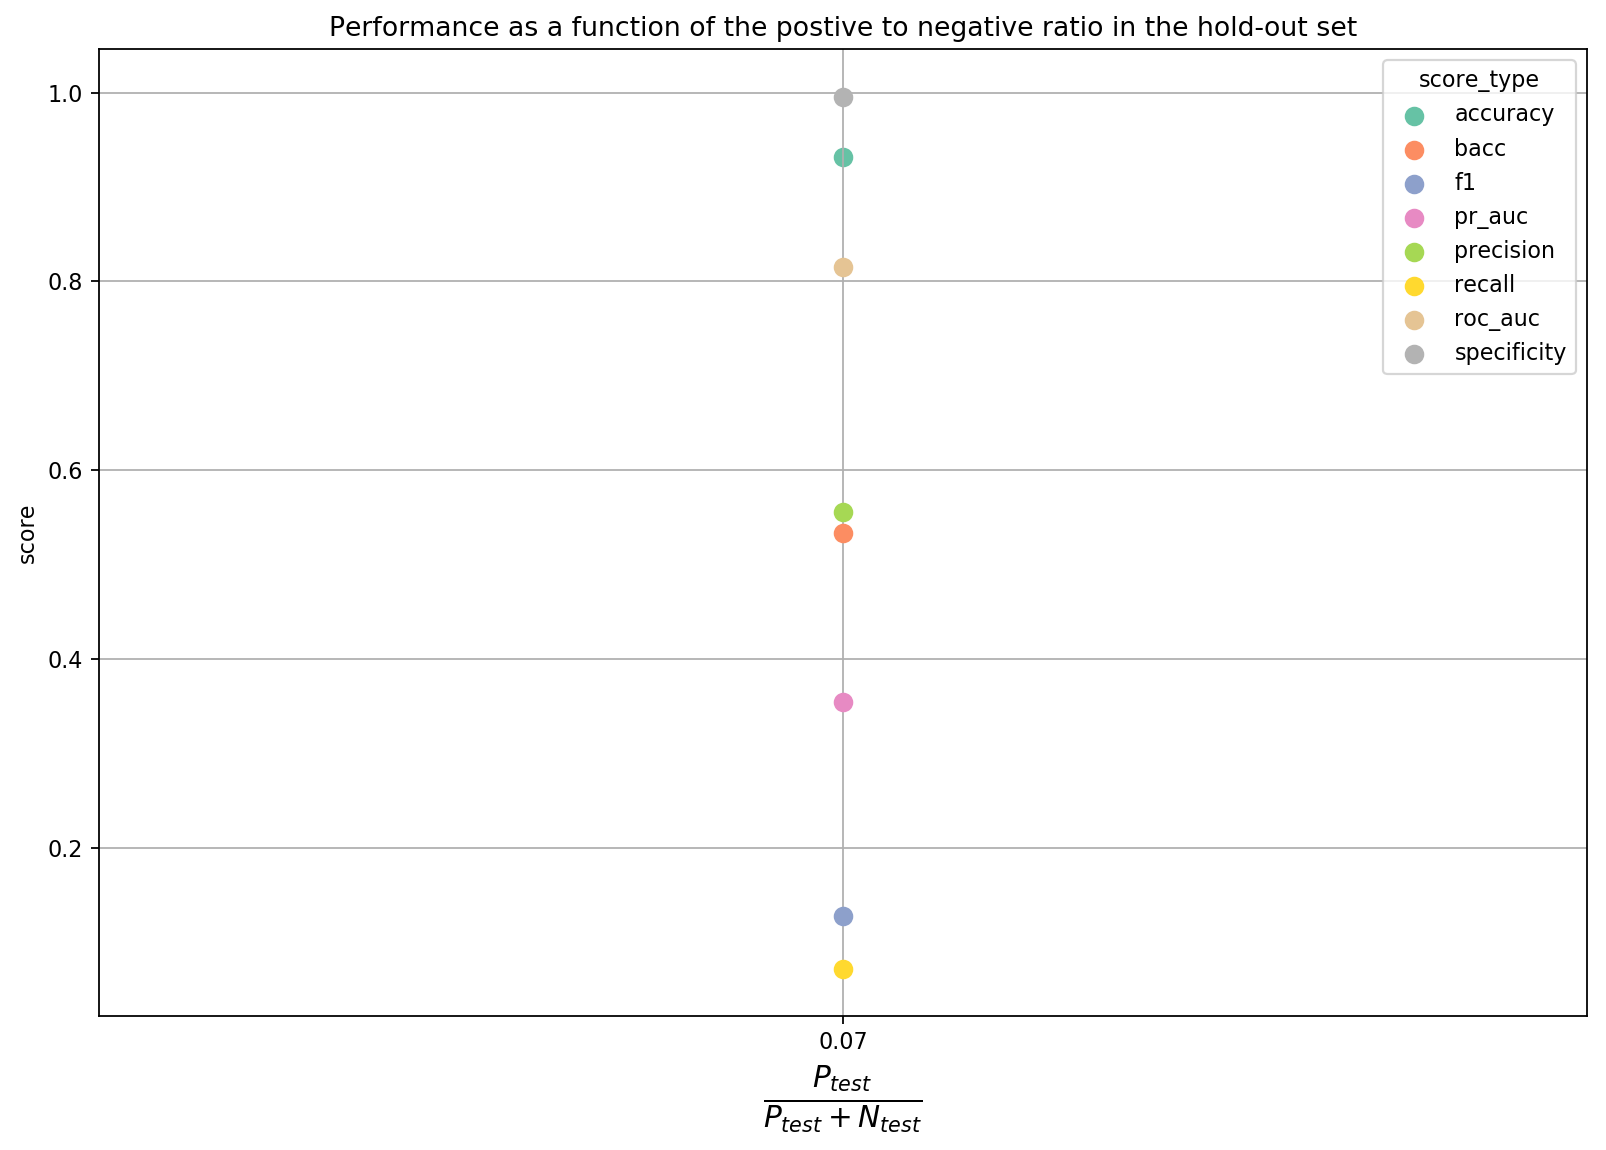

In [138]:
x = pd.melt(df, id_vars=['pos_ratio'], var_name='score_type', value_name="score")
# print(x)
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=160,
                                    facecolor='w', edgecolor='k')
ax = sns.pointplot(x="pos_ratio", y="score", hue="score_type", data=x,
              palette=sns.color_palette("Set2", 10))
ax.set_xticklabels(['%.2f' % float(l.get_text()) for l in ax.get_xticklabels()]);
ax.set_xlabel(r'$\frac{P_{test}}{P_{test}+N_{test}}$', fontsize=19)
plt.title('Performance as a function of the postive to negative ratio in the hold-out set')
plt.grid()
plt.show()